In [41]:
import pandas as pd
from utils import get_engine, plot_learning_curve
from dotenv import load_dotenv
from sqlalchemy import text
from sklearn.model_selection import GridSearchCV, learning_curve
import matplotlib.pyplot as plt

In [42]:
load_dotenv()
engine = get_engine(echo_arg=True)

In [43]:
from sklearn.metrics import r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
def get_best_estimator(pipe_list, params_list, X, y):
    estimators = []
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    for pipe, param in zip(pipe_list, params_list):
        grid = GridSearchCV(pipe, param, scoring='r2', n_jobs=-1, verbose=2)
        grid.fit(X_train, y_train)
        estimators.append(grid.best_estimator_)
    return estimators

def multi_regression(estimators, X, y):
    models, scores = ([], [])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    for estimator in estimators:
        model = MultiOutputRegressor(estimator, n_jobs=-1).fit(X_train, y_train)
        models.append(model)
        scores.append(model.score(X_test, y_test))
    return models, scores
        

In [44]:
def plot_results(X, y, estimator, result):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
    y_pred = estimator.predict(X_test)
    a = [0, 8]
    b = [0, 8]
    print(result)
    plt.scatter(y_pred, y_test, color='blue')
    plt.plot(a, b, 'r--')
    plt.title('result')
    plt.show()

In [45]:
with engine.begin() as conn:
    query = text("""SELECT * FROM "CO2_selected_colums_for_lm_no_outlier_prepared_6_colums"; """)
    df = pd.read_sql(query, conn)

2023-06-22 13:22:28,113 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2023-06-22 13:22:28,115 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-06-22 13:22:28,159 INFO sqlalchemy.engine.Engine select current_schema()
2023-06-22 13:22:28,161 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-06-22 13:22:28,204 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2023-06-22 13:22:28,206 INFO sqlalchemy.engine.Engine [raw sql] {}


2023-06-22 13:22:28,250 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-06-22 13:22:28,260 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname_1)s
2023-06-22 13:22:28,263 INFO sqlalchemy.engine.Engine [generated in 0.00283s] {'table_name': <sqlalchemy.sql.elements.TextClause object at 0x7f47a8998670>, 'param_1': 'r', 'param_2': 'p', 'param_3': 'f', 'param_4': 'v', 'param_5': 'm', 'nspname_1': 'pg_catalog'}
2023-06-22 13:22:28,266 INFO sqlalchemy.engine.Engine SELECT * FROM "CO2_selected_colums_for_lm_no_outlier_prepared_6_colums"; 
2023-06-22 13:22:28,268 INFO sqlalchemy.engine.Engin

In [46]:
df.columns

Index(['YearBuilt', 'BuildingType', 'Neighborhood', 'Have_Stream_Energy',
       'Have_Electricity_Energy', 'Have_NaturalGas_Energy',
       'PrimaryPropertyType', 'NumberofBuildings', 'LargestPropertyUseTypeGFA',
       'TotalGHGEmissions', 'SiteEnergyUse_kBtu_',
       'LargestPropertyUseTypeGFA_log', 'TotalGHGEmissions_log',
       'SiteEnergyUse_kBtu_log'],
      dtype='object')

In [47]:
y_multi = df[['TotalGHGEmissions_log', 'SiteEnergyUse_kBtu_log']]
y1, y2 = df['TotalGHGEmissions_log'], df['SiteEnergyUse_kBtu_log']

In [48]:
X_cols = [
    'Have_Stream_Energy',
    'Have_NaturalGas_Energy', 
    'PrimaryPropertyType',
    'BuildingType',
    'LargestPropertyUseTypeGFA_log',
    ]

In [49]:
X = df[X_cols]

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge, BayesianRidge
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

In [51]:
X_cat = X.select_dtypes(include=[object, bool])
X_num = X.select_dtypes(exclude=[object, bool])

ridge = Ridge()
bay_ridge = BayesianRidge()
svr = SVR()
nn = MLPRegressor(early_stopping=True)

preparation = ColumnTransformer(transformers=[
    ('tf_cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), X_cat.columns),
    ('tf_num', StandardScaler(), X_num.columns),
])

pipe_ridge = Pipeline(steps=[
    ('preparation', preparation),
    ('model', ridge)
])

pipe_bay_ridge = Pipeline(steps=[
    ('preparation', preparation),
    ('model', bay_ridge)
])

pipe_svr= Pipeline(steps=[
    ('preparation', preparation),
    ('model', svr)
])

pipe_nn= Pipeline(steps=[
    ('preparation', preparation),
    ('model', nn)
])

In [52]:
params_ridge = {'model__solver': ['auto', 'svd']}
params_bay_ridge = {'model__n_iter': [200, 300, 400]}
params_svr = {'model__C': [1.0, 2.0]}
params_nn = {'model__solver': ['adam', 'sgd'], 
             'model__hidden_layer_sizes': [60]}

In [53]:
pipe_list = [pipe_ridge, pipe_bay_ridge, pipe_svr, pipe_nn]
params_list = [params_ridge, params_bay_ridge, params_svr, params_nn]
names = ['Ridge', 'Baysian Ridge', 'SVR', 'MLP', 'Extra Tree']

In [54]:
estimators = get_best_estimator(pipe_list, params_list, X, y1)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[CV] END .................................model__solver=auto; total time=   0.1s
[CV] END ..................................model__solver=svd; total time=   0.1s
[CV] END ..................................model__solver=svd; total time=   0.1s
[CV] END ..................................model__solver=svd; total time=   0.1s
[CV] END .................................model__solver=auto; total time=   0.1s
[CV] END .................................model__solver=auto; total time=   0.1s
[CV] END ..................................model__solver=svd; total time=   0.1s
[CV] END .................................model__solver=auto; total time=   0.1s
[CV] END .................................model__solver=auto; total time=   0.1s
[CV] END ..................................model__solver=svd; total time=   0.1s
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ..................................model__n_iter=200; total time=   0.1s
[CV] END ..................................model_

/home/dakoro/Data_IA/TP/CO2_Manuel_David/co2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dakoro/Data_IA/TP/CO2_Manuel_David/co2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ....model__hidden_layer_sizes=60, model__solver=sgd; total time=   6.0s
[CV] END ....model__hidden_layer_sizes=60, model__solver=sgd; total time=   6.1s


/home/dakoro/Data_IA/TP/CO2_Manuel_David/co2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ....model__hidden_layer_sizes=60, model__solver=sgd; total time=   6.3s


/home/dakoro/Data_IA/TP/CO2_Manuel_David/co2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dakoro/Data_IA/TP/CO2_Manuel_David/co2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ....model__hidden_layer_sizes=60, model__solver=sgd; total time=   4.7s
[CV] END ....model__hidden_layer_sizes=60, model__solver=sgd; total time=   4.7s


In [55]:
models, scores = multi_regression(estimators, X, y_multi)

In [56]:
for score in scores:
    print(score)

0.800128312786504
0.8001007465921997
0.8110076728048917
0.8040295278339487


0.800128312786504


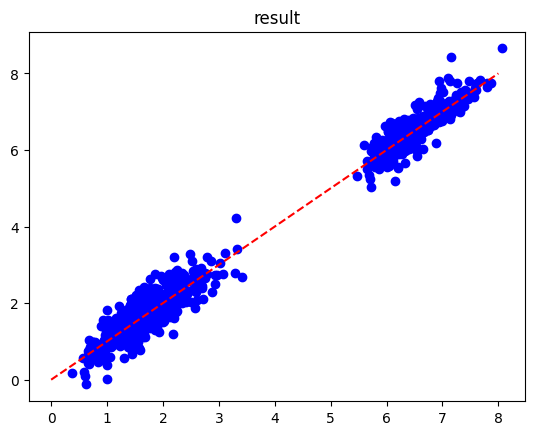

0.8001007465921997


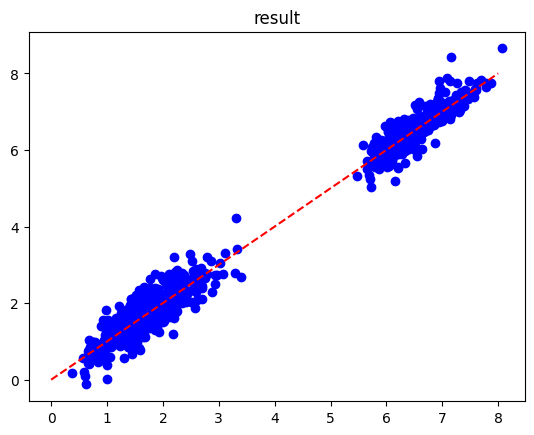

0.8110076728048917


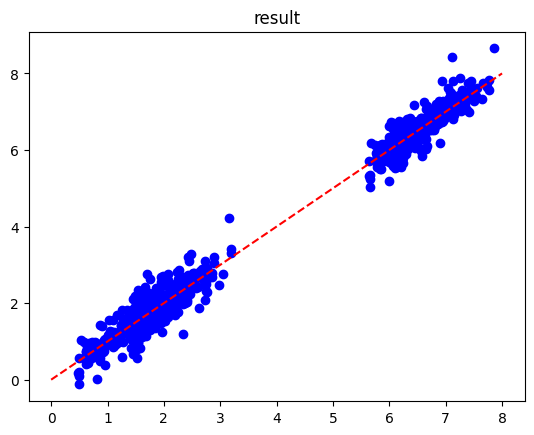

0.8040295278339487


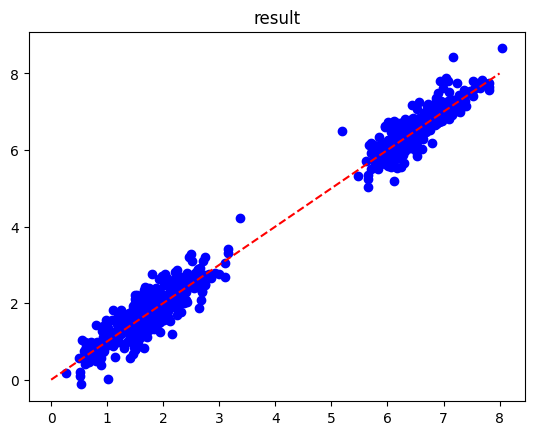

In [57]:
for estimator, score in zip(models, scores):
    plot_results(X, y_multi, estimator, score)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y_multi, test_size=0.2, random_state=42)

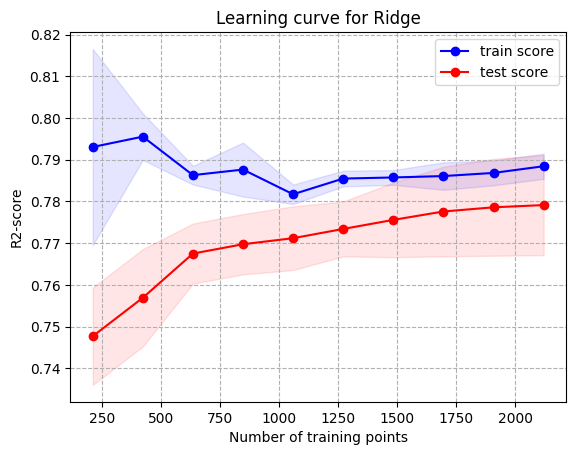

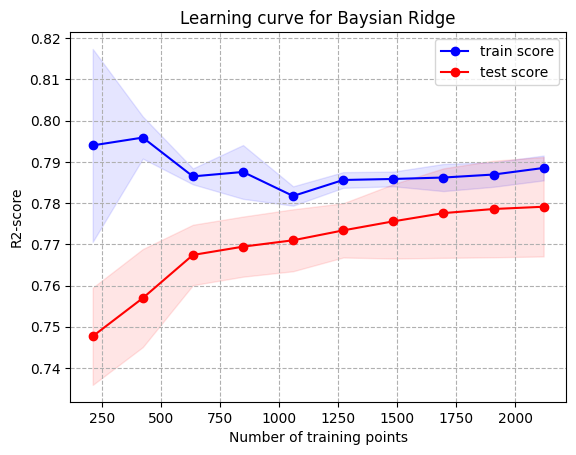

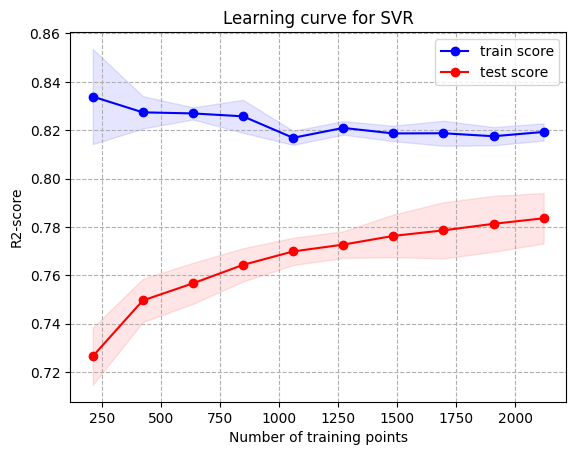

/home/dakoro/Data_IA/TP/CO2_Manuel_David/co2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dakoro/Data_IA/TP/CO2_Manuel_David/co2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dakoro/Data_IA/TP/CO2_Manuel_David/co2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dakoro/Data_IA/TP/CO2_Manuel_David/co2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

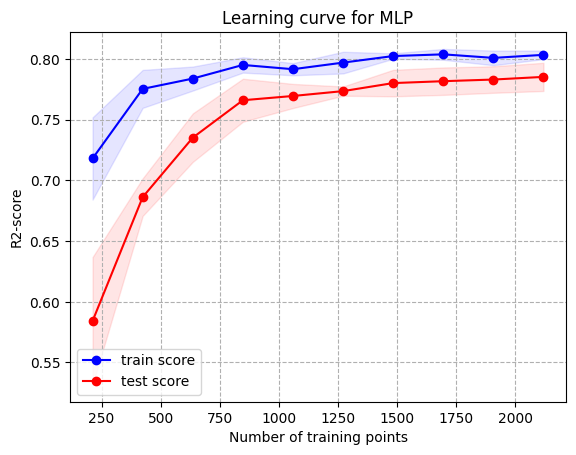

In [59]:
import numpy as np
for model, name in zip(models, names):
    title = f'Learning curve for {name}'
    train_sizes, train_scores, test_scores = learning_curve(
            estimator=model, X=X_train, y=y_train,
            train_sizes=np.arange(0.1, 1.1, 0.1), cv=5, scoring='r2', n_jobs=- 1)
    plot_learning_curve(train_sizes, train_scores, test_scores, title=title)

In [63]:
import joblib
fns = ['ridge.pkl', 'bay_ridge.pkl', 'svr.pkl', 'mlp.pkl']
for model, fn in zip(models, fns):
    print(fn, score)
    if fn == 'mlp.pkl':
        path = f'models/{fn}'
        joblib.dump(model, path)

ridge.pkl 0.8040295278339487
bay_ridge.pkl 0.8040295278339487
svr.pkl 0.8040295278339487
mlp.pkl 0.8040295278339487
